# cGAN generative model to generate images using the Yelp dataset

                                                                                                                                     By AKASH. (500227622)

Installing python libraries

In [1]:
%pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install torchvision


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install torchsummary


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Importing necessary libraries

In [4]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.models import inception_v3
from PIL import Image
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

Loading and processing Json file

In [5]:
class YelpDataset(Dataset):
    def __init__(self, json_path, img_dir, transform=None, num_samples=10000):
        self.img_dir = img_dir
        self.transform = transform
        
        # Load and process JSON
        temp_data = []
        with open(json_path, 'r') as f:
            for line in f:
                try:
                    item = json.loads(line.strip())
                    if item['label'] in ['food', 'drink', 'inside', 'outside']:
                        img_path = os.path.join(self.img_dir, item['photo_id'] + '.jpg')
                        if os.path.exists(img_path):
                            try:
                                
                                with Image.open(img_path) as img:
                                    img.verify()
                                temp_data.append(item)
                            except Exception as e:
                                print(f"Skipping corrupted image {img_path}: {str(e)}")
                                continue
                except json.JSONDecodeError:
                    continue
                except Exception as e:
                    print(f"Error processing entry: {str(e)}")
                    continue
        
        self.label_map = {
            'food': 0,
            'drink': 1,
            'inside': 2,
            'outside': 3
        }
        
        if len(temp_data) > num_samples:
            self.data = random.sample(temp_data, num_samples)
        else:
            self.data = temp_data
            print(f"Warning: Only found {len(self.data)} valid images")
        
        print(f"Dataset initialized with {len(self.data)} images")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        while True:
            try:
                img_path = os.path.join(self.img_dir, self.data[idx]['photo_id'] + '.jpg')
                image = Image.open(img_path).convert('RGB')
                label = self.label_map[self.data[idx]['label']]
                
                if self.transform:
                    image = self.transform(image)
                    
                return image, label
            except Exception as e:
                print(f"Error loading image at index {idx}, trying next index")
                idx = (idx + 1) % len(self.data)  # Move to next image if current fails


Generator for cGAN

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.init_size = 64 // 4  
        self.l1 = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size ** 2))
        
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

Discriminator for cGAN

In [7]:
class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.output = nn.Sequential(
            nn.Linear(256 * 8 * 8 + num_classes, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        feat = self.model(img)
        feat = feat.view(feat.shape[0], -1)
        label_embedding = self.label_embedding(labels)
        feat = torch.cat((feat, label_embedding), -1)
        validity = self.output(feat)
        return validity

Training function for cGAN

In [8]:
def train_cgan(generator, discriminator, dataloader, num_epochs, latent_dim, device):
    # Loss functions
    adversarial_loss = torch.nn.BCELoss()
    
    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    for epoch in range(num_epochs):
        for i, (real_imgs, labels) in enumerate(dataloader):
            batch_size = real_imgs.shape[0]
            
            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)
            
            # Configure input
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)

            optimizer_G.zero_grad()
            
            # Sample noise and labels as generator input
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_labels = torch.randint(0, 4, (batch_size,)).to(device)
            
            gen_imgs = generator(z, gen_labels)
            
            validity = discriminator(gen_imgs, gen_labels)
            g_loss = adversarial_loss(validity, valid)
            
            g_loss.backward()
            optimizer_G.step()
            
            #Train Discriminator
            optimizer_D.zero_grad()
            
            # Loss for real images
            validity_real = discriminator(real_imgs, labels)
            d_real_loss = adversarial_loss(validity_real, valid)
            
            # Loss for fake images
            validity_fake = discriminator(gen_imgs.detach(), gen_labels)
            d_fake_loss = adversarial_loss(validity_fake, fake)
            
            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            
            d_loss.backward()
            optimizer_D.step()
            
            if i % 100 == 0:
                print(
                    f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                    f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
                )

Calculating inception and fid score

In [9]:
def calculate_inception_score(generator, num_samples=1000, batch_size=32, splits=10, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    inception_model = inception_v3(weights='DEFAULT', transform_input=False)
    inception_model.aux_logits = False
    inception_model.to(device)
    inception_model.eval()
    
    # Generate images
    generator.eval()
    all_preds = []
    
    try:
        with torch.no_grad():
            for _ in tqdm(range(num_samples // batch_size), desc="Generating samples"):
                z = torch.randn(batch_size, generator.latent_dim).to(device)
                labels = torch.randint(0, 4, (batch_size,)).to(device)
                fake_images = generator(z, labels)
                
                # Preprocess images for inception model
                fake_images = F.interpolate(fake_images, size=(299, 299), mode='bilinear', align_corners=False)
                
                if device.type == 'cuda' and torch.cuda.memory_allocated() > torch.cuda.get_device_properties(0).total_memory * 0.8:
                    inception_model.to('cpu')
                    fake_images = fake_images.cpu()
                    device = torch.device('cpu')
                
                # Get inception predictions
                pred = inception_model(fake_images)
                pred = F.softmax(pred, dim=1)
                all_preds.append(pred.cpu().numpy())
                
    except RuntimeError as e:
        print(f"Runtime error occurred: {e}")
        print("Switching to CPU...")
        #If CUDA out of memory, switch to CPU
        device = torch.device('cpu')
        inception_model.to(device)
        generator.to(device)
        return calculate_inception_score(generator, num_samples, batch_size, splits, device)
    
    all_preds = np.concatenate(all_preds, axis=0)
    
    # Calculate mean and std of inception score
    scores = []
    for i in range(splits):
        part = all_preds[(i * num_samples // splits):((i + 1) * num_samples // splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))
    
    return np.mean(scores), np.std(scores)


def calculate_fid(real_images, generated_images, batch_size=32, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    inception_model = inception_v3(weights='DEFAULT', transform_input=False)
    inception_model.fc = nn.Identity()
    inception_model.aux_logits = False
    inception_model.to(device)
    inception_model.eval()
    
    def get_activations(images):
        activations = []
        for img_batch in images.split(batch_size):
            if img_batch.shape[-1] != 299:
                img_batch = F.interpolate(img_batch, size=(299, 299), mode='bilinear', align_corners=False)
            img_batch = img_batch.to(device)
            with torch.no_grad():
                act = inception_model(img_batch)
            activations.append(act.cpu())
        return torch.cat(activations, 0)
    
    real_activations = get_activations(real_images)
    fake_activations = get_activations(generated_images)
    
    # Calculate statistics
    mu1 = torch.mean(real_activations, dim=0)
    sigma1 = torch.cov(real_activations.T)
    
    mu2 = torch.mean(fake_activations, dim=0)
    sigma2 = torch.cov(fake_activations.T)

    # Add small offset to prevent singular covariance matrices
    #offset = torch.eye(sigma1.size(0)) * 1e-6

    # Calculate FID
    diff = mu1 - mu2
    covmean = torch.sqrt(sigma1.mm(sigma2))
    
    if torch.any(torch.isnan(covmean)):
        offset = torch.eye(sigma1.size(0)) * 1e-6
        covmean = torch.sqrt((sigma1 + offset).mm(sigma2 + offset))
        
    fid = diff.dot(diff) + torch.trace(sigma1) + torch.trace(sigma2) - 2 * torch.trace(covmean)
    
    return fid.item()

In [10]:
#def generate_sample_images(generator, latent_dim):
#    generator.eval()
#    with torch.no_grad():
        # Generate one image for each label
        #labels = torch.tensor([0, 1, 2, 3, 0])  # food, drink, inside, outside, food
#        z = torch.randn(5, latent_dim)
#        generated_images = generator(z, labels)
        
        # Save images
#        for i, img in enumerate(generated_images):
#            torchvision.utils.save_image(img, f"generated_sample_{i}.png", normalize=True)

Function for generating sample images

In [11]:
def generate_sample_images(generator, latent_dim, device=None, num_samples=5, save_images=True):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  
    generator.eval()
    with torch.no_grad():
        # Generate random noise and labels
        z = torch.randn(num_samples, latent_dim).to(device)
        labels = torch.randint(0, 4, (num_samples,)).to(device)
        
        # Generate images
        generated_images = generator(z, labels)
        
        # Move images to CPU if they're on GPU
        generated_images = generated_images.cpu()

        # Denormalize images
        generated_images = (generated_images + 1) / 2  # Convert from [-1, 1] to [0, 1]

        if save_images:
            # Save the images
            for i in range(num_samples):
                img = transforms.ToPILImage()(generated_images[i])  # Convert tensor to PIL Image
                img.save(f"generated_image_{i}.png")

        # Display images
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
        for i, ax in enumerate(axes):
            ax.imshow(generated_images[i].permute(1, 2, 0))  # Convert from CxHxW to HxWxC
            ax.axis('off')
        plt.show()
        
        return generated_images


In [12]:

def train_cgan(generator, discriminator, dataloader, num_epochs, latent_dim, device):
    # Loss functions
    adversarial_loss = torch.nn.BCELoss()
    
    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    for epoch in range(num_epochs):
        for i, (real_imgs, labels) in enumerate(dataloader):
            batch_size = real_imgs.shape[0]
            
            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)
            
            # Configure input
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)
            
            #Train Generator
            optimizer_G.zero_grad()
            
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_labels = torch.randint(0, 4, (batch_size,)).to(device)
            
            gen_imgs = generator(z, gen_labels)
            
            validity = discriminator(gen_imgs, gen_labels)
            g_loss = adversarial_loss(validity, valid)
            
            g_loss.backward()
            optimizer_G.step()
            
            #Train Discriminator
            optimizer_D.zero_grad()
            
            # Loss for real images
            validity_real = discriminator(real_imgs, labels)
            d_real_loss = adversarial_loss(validity_real, valid)
            
            # Loss for fake images
            validity_fake = discriminator(gen_imgs.detach(), gen_labels)
            d_fake_loss = adversarial_loss(validity_fake, fake)
            
            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            
            d_loss.backward()
            optimizer_D.step()
            
            if i % 100 == 0:
                print(
                    f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                    f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
                )


Main function for evaluating cGAN model


Skipping corrupted image E:/yelp_images/photos\ydm3g1wUWSxJnMPgHk2JhQ.jpg: cannot identify image file 'E:/yelp_images/photos\\ydm3g1wUWSxJnMPgHk2JhQ.jpg'
Skipping corrupted image E:/yelp_images/photos\JGpfPj8VEvnq1B-Xqr3w-A.jpg: cannot identify image file 'E:/yelp_images/photos\\JGpfPj8VEvnq1B-Xqr3w-A.jpg'
Skipping corrupted image E:/yelp_images/photos\bf3ymV0YgP7B6rEoriaU2w.jpg: cannot identify image file 'E:/yelp_images/photos\\bf3ymV0YgP7B6rEoriaU2w.jpg'
Skipping corrupted image E:/yelp_images/photos\juDNZOOnkgG3QINFrulsAg.jpg: cannot identify image file 'E:/yelp_images/photos\\juDNZOOnkgG3QINFrulsAg.jpg'
Skipping corrupted image E:/yelp_images/photos\9X4YPM8nYFjf7hY8xUdc6Q.jpg: cannot identify image file 'E:/yelp_images/photos\\9X4YPM8nYFjf7hY8xUdc6Q.jpg'
Skipping corrupted image E:/yelp_images/photos\N6hL8FQ84A2DznF2S2Lp7g.jpg: cannot identify image file 'E:/yelp_images/photos\\N6hL8FQ84A2DznF2S2Lp7g.jpg'
Skipping corrupted image E:/yelp_images/photos\pY32hIagdxrL4Nsi959EQg.jpg: c

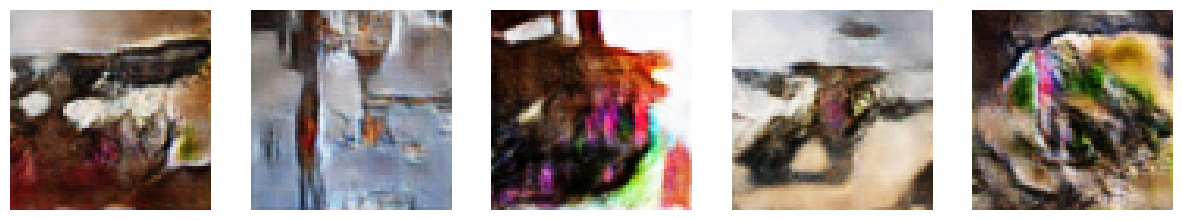

Generating samples: 100%|██████████| 31/31 [01:58<00:00,  3.84s/it]


Inception Score: 3.365866184234619 ± 0.16052080690860748


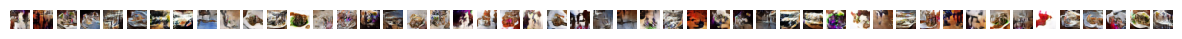

FID Score: nan


In [13]:
def main():
    # Hyperparameters
    latent_dim = 120
    num_classes = 4
    batch_size = 64
    num_epochs = 40
    image_size = 64
    
    # Device configuration
    device = torch.device('cpu')
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    
    dataset = YelpDataset(
        json_path='E:/yelp_images/photos.json',
        img_dir='E:/yelp_images/photos',
        transform=transform,
        num_samples= 10000
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize models
    generator = Generator(latent_dim, num_classes).to(device)
    discriminator = Discriminator(num_classes).to(device)
    
    # Train model
    train_cgan(generator, discriminator, dataloader, num_epochs, latent_dim, device)
    
    generate_sample_images(generator, latent_dim, device)
    
    try:
        inception_score, inception_score_std = calculate_inception_score(
            generator, num_samples=1000, batch_size=32, splits=10, device=device
        )
        print(f"Inception Score: {inception_score} ± {inception_score_std}")
    except Exception as e:
        print(f"Error calculating inception score: {e}")
        inception_score = inception_score_std = None
    
    try:
        fid_score = calculate_fid(
            next(iter(dataloader))[0], 
            generate_sample_images(generator, latent_dim, device, num_samples=50),
            batch_size=32,
            device=device
        )
        print(f"FID Score: {fid_score}")
    except Exception as e:
        print(f"Error calculating FID score: {e}")
        fid_score = None

if __name__ == "__main__":
    main()

In [14]:
#torch.save(generator.state_dict(), r"E:\yelp_images\generator.pth")


C:\Users\pc\AppData\Local\Temp\ipykernel_19512\2658064416.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(model_path, map_location=

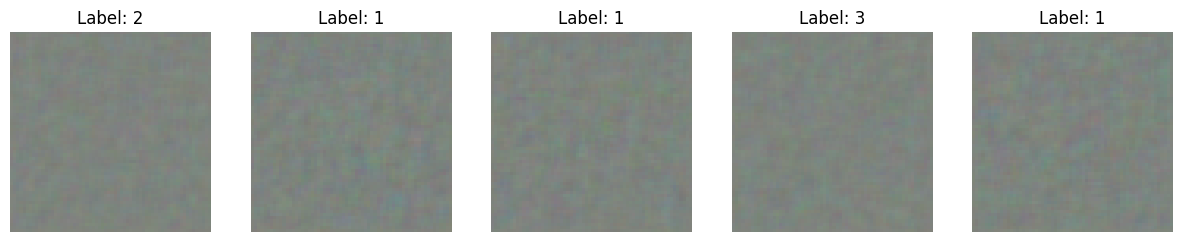

In [1]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

class Generator(torch.nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.label_emb = torch.nn.Embedding(num_classes, num_classes)
        
        self.init_size = 64 // 4  # Initial size before upsampling
        self.l1 = torch.nn.Sequential(torch.nn.Linear(latent_dim + num_classes, 128 * self.init_size ** 2))
        
        self.conv_blocks = torch.nn.Sequential(
            torch.nn.BatchNorm2d(128),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(128, 128, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128, 0.8),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(128, 64, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64, 0.8),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(64, 3, 3, stride=1, padding=1),
            torch.nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

def load_generator(model_path, latent_dim, num_classes, device):
    # Initialize generator model
    generator = Generator(latent_dim, num_classes).to(device)
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.eval()
    return generator

def generate_and_visualize(generator, latent_dim, num_classes, num_samples=5, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Generate random noise and labels
    noise = torch.randn(num_samples, latent_dim).to(device)
    labels = torch.randint(0, num_classes, (num_samples,)).to(device)

    # Generate images
    with torch.no_grad():
        generated_images = generator(noise, labels).cpu()
    
    # Denormalize images from [-1, 1] to [0, 1]
    generated_images = (generated_images + 1) / 2

    # Visualize images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, ax in enumerate(axes):
        img = transforms.ToPILImage()(generated_images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")
    plt.show()

if __name__ == "__main__":
    # Configuration
    latent_dim = 100
    num_classes = 4
    model_path = r"E:\yelp_images\generator.pth"  # Path to the trained generator model
    #generator.load_state_dict(torch.load(model_path))
    num_samples = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the generator
    generator = load_generator(model_path, latent_dim, num_classes, device)

    # Generate and visualize images
    generate_and_visualize(generator, latent_dim, num_classes, num_samples, device)
